We start with some imports and helper functions.

In [ ]:
# Nie działa na Python 3.13
import keras
from keras import layers
from keras.utils.np_utils import to_categorical
from keras import initializers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol

ModuleNotFoundError: No module named 'keras.utils.np_utils'

In [39]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol

In [40]:
def target_function(x, y):
    if abs(x) + abs(y) <= 1:
        return 1
    return 0

In [41]:
def generate_data(N):
    x = np.random.uniform(-1.4, 1.4, (N, 2))
    y = np.array([to_categorical(target_function(a,b), num_classes=2) for (a,b) in x])
    return (x, y)

In [51]:
def plot(model, grid_x, grid_y, target_f, title):
    num_layers = len(model.layers)
    num_neurons = [model.layers[n_layer].get_weights()[0].shape[1] for n_layer in range(num_layers)]
    plotting_data = [ [np.empty( (len(grid_x), len(grid_y)) ) for neuron in range(num_neurons[n_layer])] for n_layer in range(num_layers)]

    data = np.array([[x,y] for x in grid_x for y in grid_y])

    for layer in range(num_layers):
        intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
        output = intermediate_layer_model.predict(data)
        num_out = 0
        for i in range(len(grid_x)):
            for j in range(len(grid_y)):
                for (n, value) in enumerate(output[num_out]):
                    plotting_data[layer][n][j, i] = value
                num_out += 1
    
    horizontal_subplots = max(num_layers, 2)
    vertical_subplots = max(num_neurons) + 1

    fig, axs = plt.subplots(vertical_subplots, horizontal_subplots)
    plt.subplots_adjust(hspace = 0.4)

    for layer_index in range(num_layers):
        for neuron_index in range(num_neurons[layer_index]):
            pcm = axs[neuron_index, layer_index].pcolormesh(grid_x, grid_y, plotting_data[layer_index][neuron_index], vmin=0, vmax=1) #, cmap=pltcol.LinearSegmentedColormap.from_list("mycmap", ['red','blue']))
            axs[neuron_index, layer_index].set_title("Layer {}, neuron {}".format(layer_index, neuron_index))

    plt.colorbar(pcm, ax=axs[:,:])

    target = np.array([[target_f(x,y) for y in grid_y] for x in grid_x])
    axs[vertical_subplots-1, 0].pcolormesh(grid_x, grid_y, target, vmin=0, vmax=1)
    axs[vertical_subplots-1, 0].set_title("Target function")

    last_layer_index = num_layers - 1
    result = np.array([[ np.argmax( [neuron_output[x,y] for neuron_output in plotting_data[last_layer_index]] ) / (len(plotting_data[last_layer_index]) - 1)
                         for y in range(len(grid_y))] for x in range(len(grid_x))])
    axs[vertical_subplots-1, last_layer_index].pcolormesh(grid_x, grid_y, result, vmin=0, vmax=1)
    axs[vertical_subplots-1, last_layer_index].set_title("argmax(layer {} output)".format(last_layer_index))

    fig.suptitle(title)


First we will take a net with 2 layers, each having 2 neurons.

In [52]:
model = keras.Sequential()
model.add(layers.Dense(2, input_dim=2, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))

C:\Users\dejvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mse')

Let us take weights from the example file:

In [54]:
model.layers[0].set_weights([np.array(((-0.2,0.3), (.5,-0.6))).T, np.array((0.1,-0.4))])
model.layers[1].set_weights([np.array(((-0.25,0.35), (.55,-0.65))).T, np.array((0.15,-0.45))])

Let us see how the network behaves before training. On the left, two top pictures show outputs of the neurons from the first layer -- for each point (x,y) in the square $[-2,2]^2$, we show the output value by colours from black (0) to yellow (1.0). Note that for training we use only points from a square $[-1.4, 1.4]^2$. Bottom left part shows the target function. Two top graphs on the right are the output of the neurons from the second layer (i.e., the output of the network), and right bottom picture shows predictions. In this example, every point is predicted to be in class 0 (the black one). 

In [55]:
# Dodaj tę linię przed wywołaniem plot()
_ = model.predict(np.array([[0, 0]]))  # dowolne dane wejściowe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


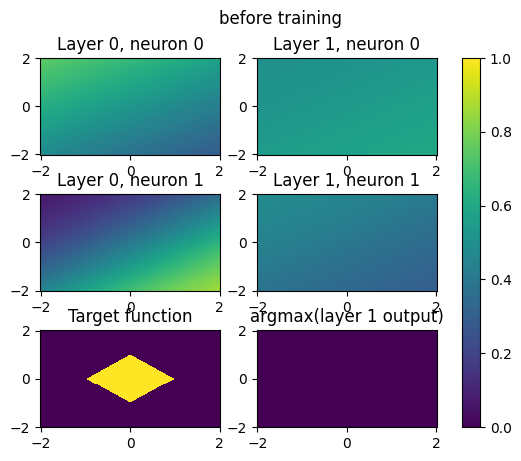

In [56]:
plot(model, np.linspace(-2,2,100), np.linspace(-2,2,100), target_function, "before training")

Now let us train the network.

In [57]:
x, y = generate_data(10000)
model.fit(x, y, batch_size=10, epochs=45)

Epoch 1/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - loss: 0.1923
Epoch 2/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 0.1900
Epoch 3/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.1899
Epoch 4/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.1898
Epoch 5/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - loss: 0.1896
Epoch 6/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - loss: 0.1896
Epoch 7/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 0.1895
Epoch 8/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - loss: 0.1894
Epoch 9/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.1892
Epoch 10/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - loss: 0.1892
Epoch 11/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - loss: 0.1889
Epoch 12/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - loss: 0.1887
Epoch 13/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.1884
Epoch 14/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - loss: 0.1879
E

...and see how it behaves after the training. It is much better, but with only 2 neurons in the first layer, it is unable to model the square target shape.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


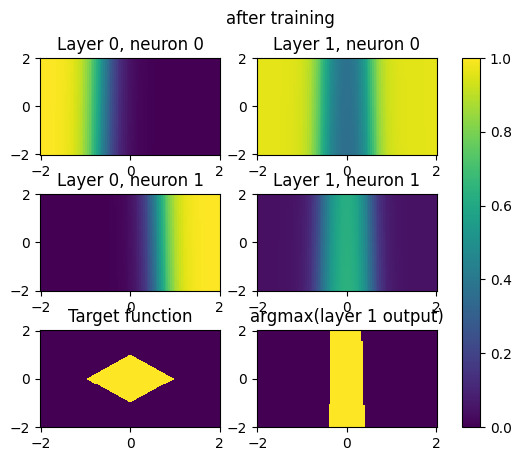

In [58]:
plot(model, np.linspace(-2,2,100), np.linspace(-2,2,100), target_function, "after training")

Let us try with 5 neurons in the first layer.

In [60]:
np.random.seed(2)   # should give reproducible results, at least using Theano backend
model = keras.Sequential()
model.add(layers.Dense(5, input_dim=2, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=1), bias_initializer=initializers.Zeros()))
model.add(layers.Dense(2, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=1), bias_initializer=initializers.Zeros()))
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mse')

C:\Users\dejvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
x, y = generate_data(10000)
model.fit(x, y, batch_size=10, epochs=45)

Epoch 1/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 0.1921
Epoch 2/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - loss: 0.1896
Epoch 3/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.1889
Epoch 4/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - loss: 0.1881
Epoch 5/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.1869
Epoch 6/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.1851
Epoch 7/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - loss: 0.1823
Epoch 8/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.1780
Epoch 9/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 0.1718
Epoch 10/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 0.1631
Epoch 11/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.1516
Epoch 12/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - loss: 0.1378
Epoch 13/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - loss: 0.1231
Epoch 14/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - loss: 0.1089
E

Let us examine the behaviour of this network after training. This one can recognise the square shape quite well. Note that neuron 1 from layer 0 outputs similar values for all points.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


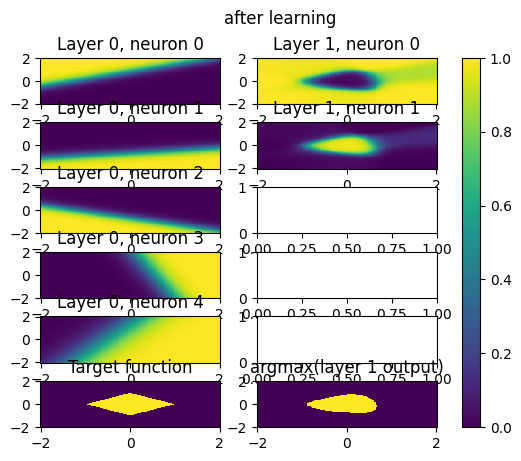

In [62]:
plot(model, np.linspace(-2,2,100), np.linspace(-2,2,100), target_function, "after learning")

Now let us come back to the net with just 2 neurons in each layer and initialise weights to zero:

In [65]:
model = keras.Sequential()
model.add(layers.Dense(2, input_dim=2, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mse')
model.layers[0].set_weights([np.zeros((2,2)), np.zeros((2,))])
model.layers[1].set_weights([np.zeros((2,2)), np.zeros((2,))])

C:\Users\dejvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 0.1944
Epoch 2/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.1907
Epoch 3/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - loss: 0.1906
Epoch 4/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - loss: 0.1907
Epoch 5/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.1907
Epoch 6/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 583us/step - loss: 0.1907
Epoch 7/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 0.1907
Epoch 8/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.1907
Epoch 9/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - loss: 0.1907
Epoch 10/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - loss: 0.1907
Epoch 11/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - loss: 0.1907
Epoch 12/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step - loss: 0.1907
Epoch 13/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.1907
Epoch 14/45
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.1907
E

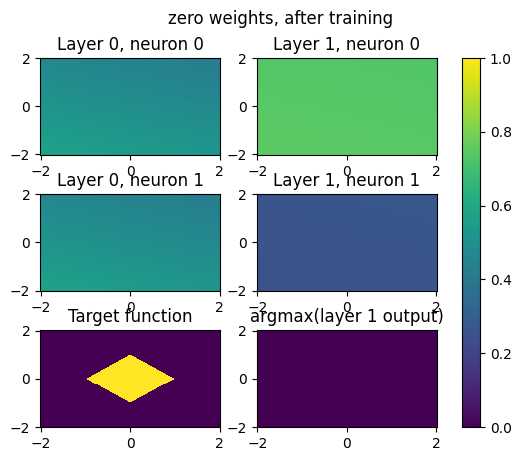

In [66]:
x, y = generate_data(10000)
model.fit(x, y, batch_size=10, epochs=45)
plot(model, np.linspace(-2,2,100), np.linspace(-2,2,100), target_function, "zero weights, after training")

As one can see above, the network performs very poorly. Examining the weights reveals the reason for that: when initial weights are all the same (within a hidden layer), by symmetry, the neurons in that layer evolve in the same way. As a result, it is like we had only 1 neuron in that layer and this leads to poor performance.

In [16]:
model.get_weights()   # compare columns of the first array

[array([[-0.08791123, -0.08791123],
        [ 0.08488268,  0.08488268]], dtype=float32),
 array([-0.02046185, -0.02046185], dtype=float32),
 array([[ 0.3661374 , -0.36613744],
        [ 0.3661374 , -0.36613744]], dtype=float32),
 array([ 0.7271915, -0.7271915], dtype=float32)]

On the other hand, if the weights are too large (with respect to the number of inputs), then the neurons saturate and the training is very slow. Let us see such an example, you may see weight $-117.57395$ (at least if the seed gives reproducible results).

[[-117.57395    28.345278]
 [ -90.79815    52.419914]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'n

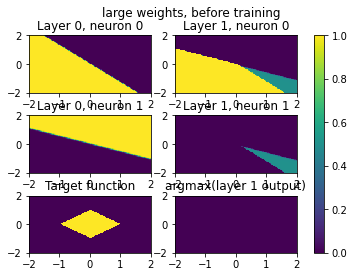

In [17]:
np.random.seed(2)   # should give reproducible results, at least using Theano backend
model = keras.Sequential()
model.add(layers.Dense(2, input_dim=2, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=100), bias_initializer=initializers.Zeros()))
model.add(layers.Dense(2, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=100), bias_initializer=initializers.Zeros()))
optimizer = keras.optimizers.SGD(lr=0.1)
model.compile(optimizer=optimizer, loss='mse')
print(model.layers[0].get_weights()[0])
plot(model, np.linspace(-2,2,100), np.linspace(-2,2,100), target_function, "large weights, before training")

Let us train the network.

In [18]:
x, y = generate_data(10000)
model.fit(x, y, batch_size=10, epochs=45)

Epoch 1/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3837
Epoch 2/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3793
Epoch 3/45
10000/10000 [==============================] - 0s 31us/step - loss: 0.3776
Epoch 4/45
10000/10000 [==============================] - 0s 33us/step - loss: 0.3767
Epoch 5/45
10000/10000 [==============================] - 0s 33us/step - loss: 0.3763
Epoch 6/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3760
Epoch 7/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3758
Epoch 8/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3756
Epoch 9/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3756
Epoch 10/45
10000/10000 [==============================] - 0s 33us/step - loss: 0.3755
Epoch 11/45
10000/10000 [==============================] - 0s 32us/step - loss: 0.3754
Epoch 12/45
10000/10000 [===========================

Let us examine the same weights again, after training. The weight that had value $−117.57395$ now has a value $-117.63838$. The other weights are also almost the same. The network virtually stays unchanged despite training.

In [19]:
print(model.layers[0].get_weights()[0])

[[-117.63838    28.087534]
 [ -90.73178    52.597485]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'n

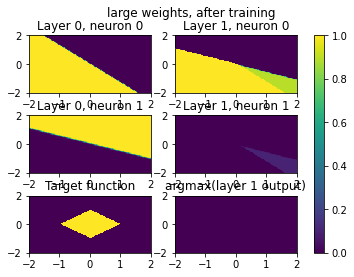

In [20]:
plot(model, np.linspace(-2,2,100), np.linspace(-2,2,100), target_function, "large weights, after training")